# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

[Load & Clean Dataset](#load) <br>
[Exploratory Data Analysis](#EDA) <br>
[Feature Engineering](#FE) <br>
[Modeling](#Modeling)

In [ ]:
#https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import max as sparkMax
from pyspark.sql.types import IntegerType, StringType, BooleanType, DateType, DoubleType
from pyspark.sql.window import Window
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer, OneHotEncoder, Normalizer
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from sklearn.metrics import roc_curve, auc

import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Project") \
    .getOrCreate()

In [3]:
# check Spark session
spark.sparkContext.getConf().getAll()

[('spark.master', 'local'),
 ('spark.driver.port', '42787'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '734797a7ccaa'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1636872736870'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'Sparkify Project')]

In [4]:
spark

<a id="load"></a>

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

### Load Data

In [5]:
path = "mini_sparkify_event_data.json"
event_log = spark.read.json(path)
#event_log.persist()

In [6]:
def shape(df):
    '''
    Replicated shape function used in Pandas to display number 
    of rows and columns in dataframe
    '''
    rows, cols = df.count(), len(df.columns)
    shape = (rows, cols)
    return shape

In [7]:
shape(event_log)

(286500, 18)

### Check for missing values

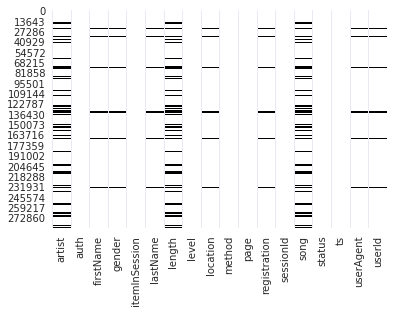

In [8]:
# visualise missing values
# https://stackoverflow.com/questions/60878196/seaborn-rc-parameters-for-set-context-and-set-style

viz_dict = {'axes.titlesize': 18,
            'axes.labelsize': 16,
            'figure.figsize': (7, 7),
            'font_scale': 0.7
            }

sns.set_context("notebook", rc=viz_dict)
sns.set_style("darkgrid")
cmap = sns.cubehelix_palette(dark=0, light=1, as_cmap=True)

sns.heatmap(event_log.toPandas().replace('', np.nan).isnull(), cbar=False, cmap=cmap);


On closer inspection it appears that some of the missing values are not classed as NaN but just empty strings. The code below counts all these variations to get an accurate count of missing values by column. 

In [9]:
event_log.select([F.count(F.when(F.col(c).contains('None') |
                          F.col(c).contains('NULL') |
                        (F.col(c) == '') |
                        F.col(c).isNull() |
                        F.isnan(c), c
                 )).alias(c)
                    for c in event_log.columns]).show(vertical=True)

-RECORD 0--------------
 artist        | 58406 
 auth          | 0     
 firstName     | 8346  
 gender        | 8346  
 itemInSession | 0     
 lastName      | 8346  
 length        | 58392 
 level         | 0     
 location      | 8346  
 method        | 0     
 page          | 0     
 registration  | 8346  
 sessionId     | 0     
 song          | 58445 
 status        | 0     
 ts            | 0     
 userAgent     | 8346  
 userId        | 8346  



8.3k records are missing userIds. On inspection, these were logged out or guest users. I will filter these records out from the data set

In [6]:
#filter out records without a used id
event_log = event_log.filter(F.col('userId') > 0)

<a id="EDA"></a>

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [5]:
event_log.show(n=1, vertical=True)

-RECORD 0-----------------------------
 artist        | Martha Tilston       
 auth          | Logged In            
 firstName     | Colin                
 gender        | M                    
 itemInSession | 50                   
 lastName      | Freeman              
 length        | 277.89016            
 level         | paid                 
 location      | Bakersfield, CA      
 method        | PUT                  
 page          | NextSong             
 registration  | 1538173362000        
 sessionId     | 29                   
 song          | Rockpools            
 status        | 200                  
 ts            | 1538352117000        
 userAgent     | Mozilla/5.0 (Wind... 
 userId        | 30                   
only showing top 1 row



In [4]:
event_log.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [5]:
event_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
event_log.describe().show()

KeyboardInterrupt: 

In [ ]:
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|              278154|           286500|              228108|            286500|              286500|              278154|           286500|
|   mean| 551.0852017937219|      null|     null|  null|114.41421291448516|    null|249.1171819778458|  null|             null|  null|   null|1.535358834084427...|1041.526554973822|            Infinity|210.05459685863875|1.540956889810483...|                null|59682.02278593872|
| stddev|1217.7693079161374|      null|     null|  null|129.76726201140994|    null|99.23517921058361|  null|             null|  null|   null| 3.291321616327586E9|726.7762634630741|                 NaN| 31.50507848842214|1.5075439608226302E9|                null|109091.9499991047|
|    min|               !!!| Cancelled| Adelaida|     F|                 0|   Adams|          0.78322|  free|       Albany, OR|   GET|  About|       1521380675000|                1|ÃÂg ÃÂtti Gr...|               200|       1538352117000|"Mozilla/5.0 (Mac...|                 |
|    max| ÃÂlafur Arnalds|Logged Out|   Zyonna|     M|              1321|  Wright|       3024.66567|  paid|Winston-Salem, NC|   PUT|Upgrade|       1543247354000|             2474|ÃÂau hafa slopp...|               404|       1543799476000|Mozilla/5.0 (comp...|               99|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+

In [10]:
def count_dist(df, field):
    '''
    count distinct records for given field
    '''
    return df.select(field).distinct().count()

In [14]:
# count number of artists
count_dist(event_log, 'artist')

17656

In [15]:
# count number of songs
count_dist(event_log, 'song')

58481

In [13]:
# most popular songs
event_log.filter(event_log.song != 'null').groupBy('song').count().\
    sort("count", ascending=False).show()

+--------------------+-----+
|                song|count|
+--------------------+-----+
|      You're The One| 1153|
|                Undo| 1026|
|             Revelry|  854|
|       Sehr kosmisch|  728|
|Horn Concerto No....|  641|
|Dog Days Are Over...|  574|
|             Secrets|  466|
|        Use Somebody|  459|
|              Canada|  435|
|             Invalid|  424|
|    Ain't Misbehavin|  409|
|       ReprÃÂ©sente|  393|
|SinceritÃÂ© Et J...|  384|
|Catch You Baby (S...|  373|
|              Yellow|  343|
|    Somebody To Love|  343|
|    Hey_ Soul Sister|  334|
|            The Gift|  327|
|           Fireflies|  312|
|          Love Story|  309|
+--------------------+-----+
only showing top 20 rows



In [14]:
# most popular artists
event_log.filter(event_log.artist != 'null').groupBy('artist').count().\
    sort("count", ascending=False).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
|       Guns N' Roses|  713|
+--------------------+-----+
only showing top 20 rows



In [15]:
# count auth types
event_log.groupBy('auth').count().sort("count", ascending=False).show()

+----------+------+
|      auth| count|
+----------+------+
| Logged In|278102|
|Logged Out|  8249|
|     Guest|    97|
| Cancelled|    52|
+----------+------+



In [6]:
# count auth types
event_log.groupBy('Gender').count().sort("count", ascending=False).show()

+------+------+
|Gender| count|
+------+------+
|     F|154578|
|     M|123576|
|  null|  8346|
+------+------+



In [28]:
# most frequently visited pages
event_log.groupBy('page').count().sort("count", ascending=False).\
    show(truncate=False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|NextSong                 |228108|
|Thumbs Up                |12551 |
|Home                     |10082 |
|Add to Playlist          |6526  |
|Add Friend               |4277  |
|Roll Advert              |3933  |
|Logout                   |3226  |
|Thumbs Down              |2546  |
|Downgrade                |2055  |
|Settings                 |1514  |
|Help                     |1454  |
|Upgrade                  |499   |
|About                    |495   |
|Save Settings            |310   |
|Error                    |252   |
|Submit Upgrade           |159   |
|Submit Downgrade         |63    |
|Cancel                   |52    |
|Cancellation Confirmation|52    |
+-------------------------+------+



In [10]:
print("total records: {}".format(event_log.count()))
print("unique users: {}".format(count_dist(event_log, 'userId')))

total records: 278154
unique users: 225


In [7]:
# add churn flag + count by churned/retained
churned = event_log.filter(event_log.page == 'Cancellation Confirmation')\
            .select('userID').dropDuplicates().rdd.flatMap(lambda x: x).collect()

event_log = event_log\
.withColumn('churn_ind', F.when(F.col("userId").isin(churned), 1).otherwise(0))

event_log.groupBy("churn_ind").agg(F.countDistinct("userId").alias('user_count')).show()

+---------+----------+
|churn_ind|user_count|
+---------+----------+
|        1|        52|
|        0|       173|
+---------+----------+



In [13]:
# group by churn status and gender
event_log.groupBy("churn_ind", "gender").agg(F.countDistinct("userId")
                                             .alias('user_count')).show()

+---------+------+----------+
|churn_ind|gender|user_count|
+---------+------+----------+
|        1|     F|        20|
|        0|     M|        89|
|        1|     M|        32|
|        0|     F|        84|
+---------+------+----------+



In [12]:
# get most recent level for each user
status = event_log.withColumn("last_record", F.row_number()\
                           .over(Window.partitionBy("userId").orderBy(F.desc("ts")))\
                           .cast(IntegerType()))


In [13]:
status.filter(status.last_record == 1).groupBy('level', 'churn_ind')\
                                        .count().sort("count", ascending=False).show()

+-----+---------+-----+
|level|churn_ind|count|
+-----+---------+-----+
| paid|        0|  114|
| free|        0|   59|
| paid|        1|   31|
| free|        1|   21|
+-----+---------+-----+



In [24]:
# most frequently played artists
event_log.filter(event_log.page == 'NextSong').select('Artist')\
    .groupBy('Artist').agg({'Artist':'count'}).sort(F.desc('count(Artist)')).show()

+--------------------+-------------+
|              Artist|count(Artist)|
+--------------------+-------------+
|       Kings Of Leon|         1841|
|            Coldplay|         1813|
|Florence + The Ma...|         1236|
|       Dwight Yoakam|         1135|
|            BjÃÂ¶rk|         1133|
|      The Black Keys|         1125|
|                Muse|         1090|
|       Justin Bieber|         1044|
|        Jack Johnson|         1007|
|              Eminem|          953|
|           Radiohead|          884|
|     Alliance Ethnik|          876|
|               Train|          854|
|        Taylor Swift|          840|
|         OneRepublic|          828|
|         The Killers|          822|
|         Linkin Park|          787|
|         Evanescence|          781|
|            Harmonia|          729|
|       Guns N' Roses|          713|
+--------------------+-------------+
only showing top 20 rows



In [8]:
# calculate session time by user and session id
avg_session_time = event_log.groupby("userId", "sessionId")\
                              .agg(((F.max(event_log.ts)-F.min(event_log.ts))/(1000*60))\
                              .alias("avg_session_mins"))

In [9]:
# calcualte average session time per user:
avg_session_time = avg_session_time.groupby("userId").agg(F.avg(avg_session_time\
                                    .avg_session_mins).alias("avg_session_mins")).sort("userId")

In [10]:
# round avg session time
avg_session_time = avg_session_time.withColumn('avg_session_mins',\
                                               F.round(F.col('avg_session_mins'), 1))

In [11]:
# parse userAgent and location fields to extract useful features 
device = F.udf(lambda x: x.split('(')[1].split(";")[0].split(" ")[0]
               .replace('"', ' ').strip() if not x is None else "")

browser = F.udf(lambda x: x.rsplit(' ', 1)[1].rsplit('/', 1)[0]
                .replace('"', ' ', 1).strip() if not x is None else "")

state = F.udf(lambda x: x.split(',')[1].strip() if not x is None else "")

event_log = event_log\
    .withColumn('device', device(event_log.userAgent))\
    .withColumn('browser', browser(event_log.userAgent))\
    .withColumn('state', state(event_log.location))

In [27]:
event_log.groupBy("device").agg(F.countDistinct("userId")
                                .alias('user_count')).sort("user_count", ascending=False).show()

+----------+----------+
|    device|user_count|
+----------+----------+
|   Windows|       106|
| Macintosh|        86|
|    iPhone|        13|
|       X11|        12|
|compatible|         5|
|      iPad|         3|
+----------+----------+



In [23]:
event_log.groupBy("device", "churn_ind").agg(F.countDistinct("userId")\
                                        .alias('user_count'))\
                                        .sort("device", ascending=False).show()

+----------+---------+----------+
|    device|churn_ind|user_count|
+----------+---------+----------+
|    iPhone|        1|         4|
|    iPhone|        0|         9|
|      iPad|        0|         3|
|compatible|        0|         5|
|       X11|        0|         7|
|       X11|        1|         5|
|   Windows|        0|        82|
|   Windows|        1|        24|
| Macintosh|        0|        67|
| Macintosh|        1|        19|
+----------+---------+----------+



In [46]:
event_log.groupBy("browser").agg(F.countDistinct("userId")
                                 .alias('user_count')).sort("user_count", ascending=False).show()

+-------+----------+
|browser|user_count|
+-------+----------+
| Safari|       163|
|Firefox|        50|
|  Gecko|         7|
|Trident|         5|
+-------+----------+



In [28]:
event_log.groupBy("browser", "churn_ind").agg(F.countDistinct("userId")\
                                        .alias('user_count'))\
                                        .sort("browser", ascending=False).show()

+-------+---------+----------+
|browser|churn_ind|user_count|
+-------+---------+----------+
|Trident|        0|         5|
| Safari|        0|       128|
| Safari|        1|        35|
|  Gecko|        0|         6|
|  Gecko|        1|         1|
|Firefox|        1|        16|
|Firefox|        0|        34|
+-------+---------+----------+



In [52]:
event_log.groupBy("state").agg(F.countDistinct("userId")
                               .alias('user_count')).sort("user_count", ascending=False).show(150)

+------------+----------+
|       state|user_count|
+------------+----------+
|          CA|        33|
|          TX|        16|
|    NY-NJ-PA|        15|
|          FL|        14|
|          CT|         7|
|          AZ|         7|
|          NC|         6|
|    IL-IN-WI|         6|
|       MO-IL|         6|
|       NC-SC|         6|
| PA-NJ-DE-MD|         5|
|          NY|         5|
|          MI|         5|
|       MA-NH|         5|
|          WA|         4|
| DC-VA-MD-WV|         4|
|          AL|         4|
|          GA|         4|
|          CO|         4|
|          MS|         3|
|          KY|         3|
|          NV|         3|
|          PA|         3|
|          OH|         3|
|          IL|         3|
|       MN-WI|         3|
|          IN|         3|
|          LA|         2|
|          SC|         2|
|       VA-NC|         2|
|       RI-MA|         2|
|          MD|         2|
|          NH|         2|
|          AK|         2|
|          MT|         2|
|          V

### Create customer analytical records - new features

In [12]:
# https://sparkbyexamples.com/spark/spark-collect-list-and-collect-set-functions/
# Spark SQL function collect_set() is similar to collect_list() with difference being, collect_set() 
# dedupe or eliminates the duplicates and results in unique for each value.

user = Window().partitionBy('userId')

user_log = event_log.filter("userId != ''")\
    .withColumn('gender', F.when(F.col('gender') == "M", 1).otherwise(0))\
    .withColumn('total_events', F.count('*').over(user))\
    .withColumn('total_songs', F.count("song").over(user))\
    .withColumn('reg_dt', F.from_unixtime(F.col('registration')/1000).cast(DateType()))\
    .withColumn('min_dt',  F.from_unixtime((F.min("ts").over(user))/1000).cast(DateType()))\
    .withColumn('max_dt', F.from_unixtime((F.max("ts").over(user))/1000).cast(DateType()))\
    .withColumn('max_unix', F.max("ts").over(user))\
    .withColumn('total_sessions', F.size(F.collect_set(F.col('sessionId')).over(user)))\
    .withColumn('roll_ads', F.sum(F.when(F.col('page') == 'Roll Advert', 1).otherwise(0)).over(user))\
    .withColumn('add_friend', F.sum(F.when(F.col('page') == 'Add Friend', 1).otherwise(0)).over(user))\
    .select(*['userId', 'gender', 'total_events', 'total_songs', 'reg_dt', 'min_dt', 'max_dt', 
              'browser', 'device', 'state', 'max_unix', 'total_sessions', 'roll_ads', 'add_friend']).distinct()

**Feature: avg session time**

In [13]:
user_log = user_log.join(avg_session_time,\
                    [user_log.userId == avg_session_time.userId], how="left").\
                    select(user_log['*'], "avg_session_mins")

**Feature: unique songs**

In [14]:
# unique_songs_listened_to
songs = event_log.select('userId', 'song').dropDuplicates().groupBy('userId')\
        .count().withColumnRenamed("count", "unique_songs")

user_log = user_log.join(songs, [user_log.userId == songs.userId], how="left")\
            .select(user_log['*'], "unique_songs")

**Feature: unique artists**

In [15]:
# unique_songs_listened_to
artists = event_log.select('userId', 'artist').dropDuplicates().groupBy('userId')\
            .count().withColumnRenamed("count", "unique_artists")

user_log = user_log.join(artists, [user_log.userId == artists.userId], how="left")\
            .select(user_log['*'], "unique_artists")

**Feature: Thumbs Up**

In [16]:
# unique_songs_listened_to
likes = event_log.select('userId', 'song').filter(event_log.page == 'Thumbs Up')\
        .groupBy('userId').count().withColumnRenamed("count", "likes")

user_log = user_log.join(likes, [user_log.userId == likes.userId], how="left")\
            .select(user_log['*'], "likes")

**Feature: Thumbs Down**

In [17]:
#unique_songs_listened_to
dislikes = event_log.select('userId', 'song').filter(event_log.page == 'Thumbs Down')\
            .groupBy('userId').count().withColumnRenamed("count", "dislikes")

user_log = user_log.join(dislikes, [user_log.userId == dislikes.userId], how="left")\
            .select(user_log['*'], "dislikes")

**Feature: Songs add to playlist**

In [18]:
# songs added to playlist
playlist = event_log.select('userId', 'song').filter(event_log.page == 'Add to Playlist')\
            .groupBy('userId').count().withColumnRenamed("count", "playlist_adds")

user_log = user_log.join(playlist, [user_log.userId == playlist.userId], how="left")\
            .select(user_log['*'], "playlist_adds")

In [19]:
# convert features to ratios and add to user_log df

user_log = user_log\
    .withColumn('likes_ratio', F.round(user_log.likes/user_log.total_songs, 2))\
    .withColumn('dislikes_ratio', F.round(user_log.dislikes/user_log.total_songs, 2))\
    .withColumn('playlist_ratio', F.round(user_log.playlist_adds/user_log.total_songs, 2))\
    .withColumn('friend_ratio', F.round(user_log.add_friend/user_log.total_songs, 2))\
    .withColumn('addRoll_ratio', F.round(user_log.roll_ads/user_log.total_songs, 2))

**Feature: churn flag and tenure**

In [20]:
#churn flag and tenure using python syntax
churned = event_log.filter(event_log.page == 'Cancellation Confirmation').\
            select('userID').dropDuplicates().rdd.flatMap(lambda x: x).collect()

user_log = user_log\
.withColumn('tenure',F.datediff(F.col("max_dt"), F.col("reg_dt")))\
.withColumn('churn_ind', F.when(F.col("userId").isin(churned),1).otherwise(0))


In [49]:
user_log.groupBy("churn_ind").count().sort(("count"), ascending=False).show()

+---------+-----+
|churn_ind|count|
+---------+-----+
|        0|  173|
|        1|   52|
+---------+-----+



In [106]:
user_log.groupBy("gender").count().sort(("count"), ascending=False).show()

+------+-----+
|gender|count|
+------+-----+
|     1|  121|
|     0|  104|
+------+-----+



**Feature: User Level (last recorded status)**

In [21]:
# get most recent level for each user
user_level = event_log.groupby('userId', 'level')\
            .agg(sparkMax(event_log.ts).alias('max_ts')).sort('userId')

user_log = user_log.join(user_level, [user_log.userId == user_level.userId,
                                      user_log.max_unix == user_level.max_ts],\
                                         how = "left").select(user_log['*'], "level")

In [22]:
# drop redundant columns

cols = ("min_dt", "reg_dt", "max_dt", "max_unix", "likes", "dislikes",
        "playlist_adds", "roll_ads", "add_friend")

user_log = user_log.drop(*cols)

In [26]:
user_log.show(5, truncate=False, vertical=True)

-RECORD 0----------------------
 userId           | 200008     
 gender           | F          
 total_events     | 2012       
 total_songs      | 1669       
 reg_dt           | 2018-08-07 
 browser          | Safari     
 device           | Windows    
 state            | NC-SC      
 total_sessions   | 15         
 avg_session_mins | 452.3      
 unique_songs     | 1506       
 unique_artists   | 1160       
 likes_ratio      | 0.04       
 dislikes_ratio   | 0.03       
 playlist_ratio   | 0.03       
 friend_ratio     | 0.02       
 addRoll_ratio    | 0.0        
 tenure           | 116        
 churn_ind        | 0          
 level            | paid       
-RECORD 1----------------------
 userId           | 96         
 gender           | F          
 total_events     | 2176       
 total_songs      | 1802       
 reg_dt           | 2018-09-17 
 browser          | Safari     
 device           | Macintosh  
 state            | NJ         
 total_sessions   | 19         
 avg_ses

In [120]:
shape(user_log)

(225, 19)

In [23]:
user_log.cache()

DataFrame[userId: string, gender: int, total_events: bigint, total_songs: bigint, browser: string, device: string, state: string, total_sessions: int, avg_session_mins: double, unique_songs: bigint, unique_artists: bigint, likes_ratio: double, dislikes_ratio: double, playlist_ratio: double, friend_ratio: double, addRoll_ratio: double, tenure: int, churn_ind: int, level: string]

In [24]:
# fill null values with 0 for modeling
user_log_2 = user_log.fillna(value=0,
                             subset=['dislikes_ratio',
                                    'playlist_ratio', 'likes_ratio'])

**create pandas df for data analysis and visualisation**

In [46]:
user_log_df = user_log_2.toPandas()

In [89]:
type(user_log_df)

pandas.core.frame.DataFrame

In [149]:
user_log_df.shape

(225, 17)

In [150]:
user_log_df.dtypes

userId               object
gender               object
total_events          int64
total_songs           int64
reg_dt               object
total_sessions        int32
avg_session_mins    float64
unique_songs          int64
unique_artists        int64
likes_ratio         float64
dislikes_ratio      float64
playlist_ratio      float64
friend_ratio        float64
addRoll_ratio       float64
tenure                int32
churn_ind             int32
level                object
dtype: object

In [151]:
user_log_df.head()

,userId,gender,total_events,total_songs,reg_dt,total_sessions,avg_session_mins,unique_songs,unique_artists,likes_ratio,dislikes_ratio,playlist_ratio,friend_ratio,addRoll_ratio,tenure,churn_ind,level
0,200008,F,2012,1669,2018-08-07,15,452.3,1506,1160,0.04,0.03,0.03,0.02,0.00,116,0,paid
1,96,F,2176,1802,2018-09-17,19,392.4,1625,1238,0.05,0.01,0.03,0.02,0.01,74,0,paid
2,200002,M,474,387,2018-09-06,6,266.4,379,340,0.05,0.02,0.02,0.01,0.02,70,0,paid
3,49,M,1091,878,2018-08-15,10,356.4,814,685,0.05,0.01,0.03,0.03,0.01,107,0,paid
4,68,F,48,29,2018-08-15,2,63.7,30,30,0.07,NaN,NaN,0.24,0.14,100,0,free


In [63]:
# plot churn by device
def plot_cats(df, cat_variable):
    '''
    Function to plot categorical features vs churn status
    '''
    sns.set(style='white')    
    ax = df.groupby([cat_variable, 'churn_ind']).size().unstack().plot(kind='bar', stacked=True)
    ax.legend(title = "churn", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    ax.set_title(label=(str("{} vs. churn_status".format(cat_variable))))
    sns.despine(top=True, right=True)
    plt.show()

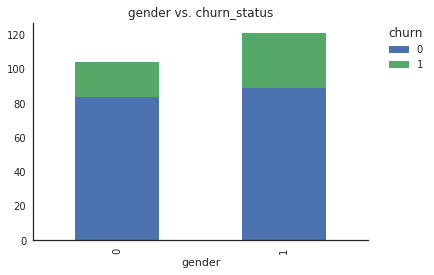

In [64]:
plot_cats(user_log_df, 'gender')

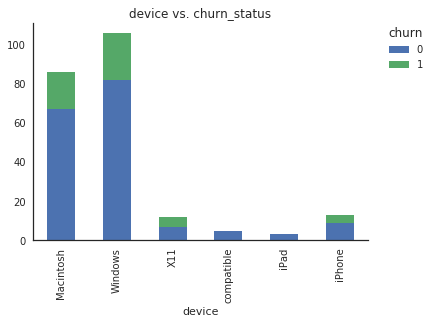

In [65]:
plot_cats(user_log_df, 'device')

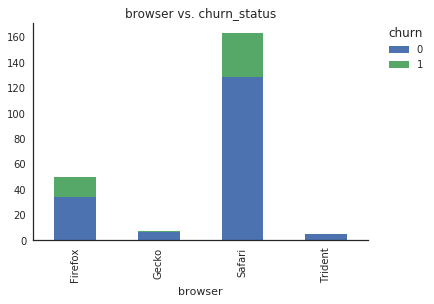

In [66]:
plot_cats(user_log_df, 'browser')

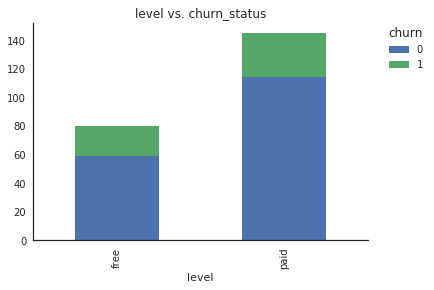

In [67]:
plot_cats(user_log_df, 'level')

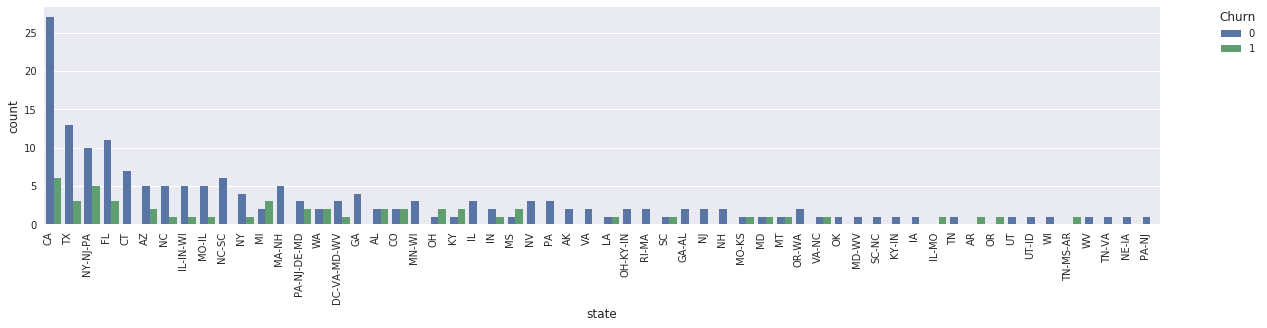

In [69]:
# plot churn by state
viz_dict = {
    'axes.titlesize':18,
    'axes.labelsize':12,
    'figure.figsize':(20, 4),
    'font_scale': 0.7
} 

#sns.set(rc={"figure.figsize":(20, 4)}) #width=3, #height=4
sns.set_context("notebook", rc=viz_dict)
#sns.set(rc=viz_dict)
ax = sns.countplot(data=user_log_df, x='state', hue='churn_ind', order=user_log_df['state'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
ax.legend(title='Churn', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show();

In [31]:
def plot_cont_relationship(variable):
    '''
    Function charts density plot for given variable split by churn/retained
    '''
    fig, ax = plt.subplots()

    sns.distplot(user_log_df[user_log_df["churn_ind"] == 1][variable], bins=10, label="churned")
    sns.distplot(user_log_df[user_log_df["churn_ind"] == 0][variable], bins=10, label="retained")

    ax.set_xlabel(variable)
    ax.set_ylabel("density")

    fig.suptitle(str("{} vs. churn_status".format(variable)))

    ax.legend();

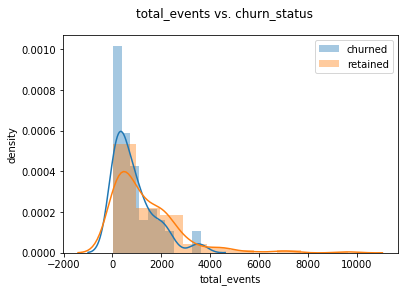

In [174]:
plot_cont_relationship("total_events")

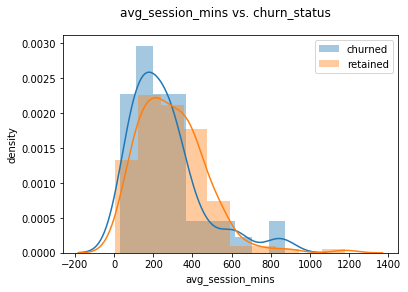

In [172]:
plot_cont_relationship("avg_session_mins")

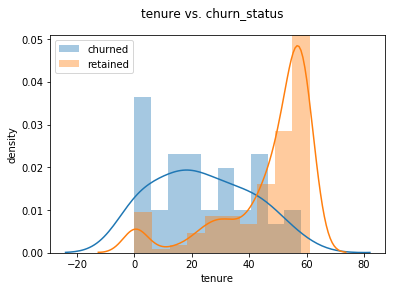

In [171]:
plot_cont_relationship("tenure")

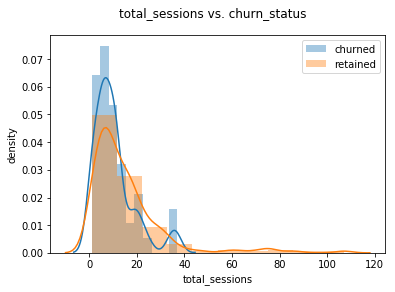

In [170]:
plot_cont_relationship("total_sessions")

**Check variable correlations**

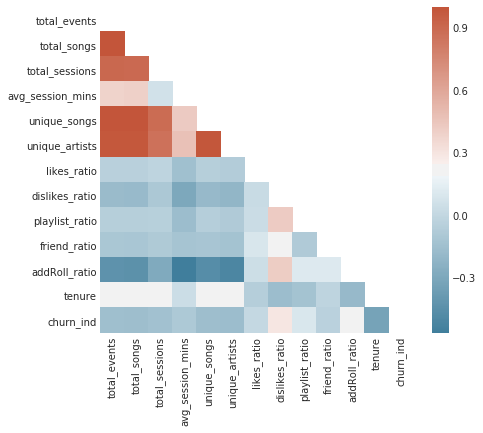

In [30]:
# Compute the correlation matrix
sns.set_style("white")
corr = user_log_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap);

In [175]:
user_log_df[user_log_df["churn_ind"] == 0].describe()

,total_events,total_songs,total_sessions,avg_session_mins,unique_songs,likes_ratio,dislikes_ratio,playlist_ratio,tenure,churn_ind
count,173.000000,173.000000,173.000000,173.00000,173.000000,170.000000,155.000000,165.000000,173.000000,173.0
mean,1348.497110,1108.173410,15.254335,296.75896,976.763006,0.055882,0.011613,0.028667,46.930636,0.0
std,1425.428637,1183.146703,15.866963,174.17181,951.918807,0.018384,0.006977,0.010565,16.124726,0.0
min,6.000000,3.000000,1.000000,7.00000,4.000000,0.020000,0.000000,0.010000,0.000000,0.0
25%,321.000000,251.000000,6.000000,166.20000,240.000000,0.050000,0.010000,0.020000,43.000000,0.0
50%,940.000000,747.000000,11.000000,268.30000,697.000000,0.050000,0.010000,0.030000,54.000000,0.0
75%,2005.000000,1640.000000,19.000000,392.20000,1478.000000,0.060000,0.010000,0.030000,58.000000,0.0
max,9632.000000,8002.000000,107.000000,1179.90000,5947.000000,0.130000,0.040000,0.090000,61.000000,0.0


In [176]:
user_log_df[user_log_df["total_songs"] == 8002]

,userId,gender,total_events,total_songs,total_sessions,avg_session_mins,unique_songs,likes_ratio,dislikes_ratio,playlist_ratio,tenure,churn_ind,level
173,39,F,9632,8002,107,306.6,5947,0.05,0.01,0.03,60,0,paid


In [25]:
# drop highly correlated variables
cols = ("total_events", "total_songs", "unique_songs", "unique_artists", "state", "userId")

user_log_2 = user_log_2.drop(*cols)

<a id="FE"></a>

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [72]:
# check for missing values
user_log_2.select([F.count(F.when(F.col(c).contains('None') |
                          F.col(c).contains('NULL') |
                        (F.col(c) == '') |
                        F.col(c).isNull() |
                        F.isnan(c), c
                 )).alias(c)
                    for c in user_log_2.columns]).show(vertical=True)

-RECORD 0---------------
 userId           | 0   
 gender           | 0   
 browser          | 0   
 device           | 0   
 state            | 0   
 total_sessions   | 0   
 avg_session_mins | 0   
 likes_ratio      | 0   
 dislikes_ratio   | 0   
 playlist_ratio   | 0   
 friend_ratio     | 0   
 addRoll_ratio    | 0   
 tenure           | 0   
 churn_ind        | 0   
 level            | 0   



In [121]:
user_log_2.show(2)

+------+-------+---------+--------------+----------------+-----------+--------------+--------------+------------+-------------+------+---------+-----+
|gender|browser|   device|total_sessions|avg_session_mins|likes_ratio|dislikes_ratio|playlist_ratio|friend_ratio|addRoll_ratio|tenure|churn_ind|level|
+------+-------+---------+--------------+----------------+-----------+--------------+--------------+------------+-------------+------+---------+-----+
|     0| Safari|  Windows|            15|           452.3|       0.04|          0.03|          0.03|        0.02|          0.0|   116|        0| paid|
|     0| Safari|Macintosh|            19|           392.4|       0.05|          0.01|          0.03|        0.02|         0.01|    74|        0| paid|
+------+-------+---------+--------------+----------------+-----------+--------------+--------------+------------+-------------+------+---------+-----+
only showing top 2 rows



In [ ]:
+------+-------+---------+--------------+----------------+-----------+--------------+--------------+------------+-------------+------+---------+-----+
|gender|browser|   device|total_sessions|avg_session_mins|likes_ratio|dislikes_ratio|playlist_ratio|friend_ratio|addRoll_ratio|tenure|churn_ind|level|
+------+-------+---------+--------------+----------------+-----------+--------------+--------------+------------+-------------+------+---------+-----+
|     0| Safari|  Windows|            15|           452.3|       0.04|          0.03|          0.03|        0.02|          0.0|   116|        0| paid|
|     0| Safari|Macintosh|            19|           392.4|       0.05|          0.01|          0.03|        0.02|         0.01|    74|        0| paid|
+------+-------+---------+--------------+----------------+-----------+--------------+--------------+------------+-------------+------+---------+-----+

In [90]:
#https://medium.com/@nutanbhogendrasharma/role-of-stringindexer-and-pipelines-in-pyspark-ml-feature-b79085bb8a6c

#from collections import defaultdict

#data_types = defaultdict(list)
#for entry in (x for x in user_log.schema.fields if x not in ['StructField(StringType,true)']):
#    data_types[str(entry.dataType)].append(entry.name)

In [109]:
user_log_2.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- browser: string (nullable = true)
 |-- device: string (nullable = true)
 |-- total_sessions: integer (nullable = false)
 |-- avg_session_mins: double (nullable = true)
 |-- likes_ratio: double (nullable = false)
 |-- dislikes_ratio: double (nullable = false)
 |-- playlist_ratio: double (nullable = false)
 |-- friend_ratio: double (nullable = true)
 |-- addRoll_ratio: double (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- churn_ind: integer (nullable = false)
 |-- level: string (nullable = true)



In [26]:
# Create pipeline to prepare data
def feature_transformation(df): 
    
    num_features = []

    for i in range(len(df.dtypes)):
        if df.dtypes[i][1] != 'string':
            num_features.append(df.dtypes[i][0])
        
    num_features.remove('churn_ind')
    
    # stage_indexer = [StringIndexer(inputCol=c, outputCol= c+"_string_encoded") for c in cat_features]
    # stage_one_hot = [OneHotEncoder(inputCol= c+"_string_encoded", outputCol= c+ "_one_hot") for c in cat_features]

    indexer_level = StringIndexer(inputCol='level', outputCol='level_index')
    indexer_device = StringIndexer(inputCol='device', outputCol='device_index')
    #indexer_browser = StringIndexer(inputCol='browser', outputCol='browser_index')

    encoder_level = OneHotEncoder(inputCol='level_index', outputCol='level_vec')
    encoder_device = OneHotEncoder(inputCol='device_index', outputCol='device_vec')
    #encoder_browser = OneHotEncoder(inputCol='browser_index', outputCol='browser_vec')

    stage_num = VectorAssembler(inputCols=num_features, outputCol="NumFeatures")
    stage_scale = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures")

    assembler_combined = VectorAssembler(inputCols=["ScaledNumFeatures", "level_vec", "device_vec"],\
                                         outputCol='features', handleInvalid='skip')

    features_pipeline = Pipeline(stages=[indexer_level, indexer_device, encoder_level, encoder_device,
                                         stage_num, stage_scale, assembler_combined])

    transformed_df = features_pipeline.fit(df).transform(df)
    return transformed_df

In [27]:
df = feature_transformation(user_log_2)
df_2 = df.select("churn_ind", "features").withColumnRenamed("churn_ind", "label")

df_2.show(2, truncate=False)

+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                                              |
+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[0.0,1.0241085630941311,2.5576146878250126,1.7368193921337345,2.7813891847993806,1.8981651986641221,0.9130143537401039,0.0,3.0830271707188546,1.0,1.0,0.0,0.0,0.0,0.0]                |
|0    |[0.0,1.2972041799192329,2.2188989686105125,2.1710242401671684,0.9271297282664602,1.8981651986641221,0.9130143537401039,0.19549619685824587,1.9667587123551313,1.0,0.0,1.0,0.0,0.0,0.0]|
+-----+--------------------------------------

In [ ]:
+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                                              |
+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[0.0,1.0241085630941311,2.5576146878250126,1.7368193921337345,2.7813891847993806,1.8981651986641221,0.9130143537401039,0.0,3.0830271707188546,1.0,1.0,0.0,0.0,0.0,0.0]                |
|0    |[0.0,1.2972041799192329,2.2188989686105125,2.1710242401671684,0.9271297282664602,1.8981651986641221,0.9130143537401039,0.19549619685824587,1.9667587123551313,1.0,0.0,1.0,0.0,0.0,0.0]|
+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+

<a id="modeling"></a>

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [29]:
# Train Test Split
train, test = df_2.randomSplit([0.7, 0.3], seed=42)

In [131]:
print(shape(train))
print(shape(test))

(163, 2)
(62, 2)


**Evaluation Metrics**

In [30]:
# Calculate accuracy and F-1 score
def evaluate_model(predictions, model):
    accuracy_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
    accuracy = accuracy_evaluator.evaluate(predictions.select(F.col('label'), F.col('prediction')))

    f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    f1_score = f1_evaluator.evaluate(predictions.select(F.col('label'), F.col('prediction')))

    print('Model: {}'.format(model))
    print('-------------------------------')
    print('Accuracy : {:.2f}'.format(accuracy))
    print('F1 score: {:.2f}'.format(f1_score))

**Random Forest**

**useful guide, that I adapted:** https://hackernoon.com/building-a-machine-learning-model-with-pyspark-a-step-by-step-guide-1z2d3ycd

In [125]:
rf = RandomForestClassifier(featuresCol='features', labelCol='label', maxDepth=5)
start_time = time.time()
rfModel = rf.fit(train)
rf_predictions = rfModel.transform(test)
end_time = time.time()
print('elapsed time = {}'.format(end_time-start_time))

elapsed time = 34.53918242454529


In [126]:
evaluate_model(rf_predictions, rfModel)

Model: RandomForestClassificationModel (uid=RandomForestClassifier_488de096438d) with 20 trees
-------------------------------
Accuracy : 0.73
F1 score: 0.67


**GBTClassifier**

In [31]:
gb = GBTClassifier(featuresCol='features', labelCol='label')
start_time = time.time()
gbModel = gb.fit(train)
gb_predictions = gbModel.transform(test)
end_time = time.time()
print('elapsed time = {}'.format(end_time-start_time))

elapsed time = 348.91199588775635


In [32]:
evaluate_model(gb_predictions, gbModel)

Model: GBTClassificationModel (uid=GBTClassifier_637f550ec742) with 20 trees
-------------------------------
Accuracy : 0.76
F1 score: 0.75


**Logistic Regression**

In [129]:
logisticReg = LogisticRegression(featuresCol='features', labelCol='label')
start_time = time.time()
lrModel = logisticReg.fit(train)
lr_predictions = lrModel.transform(test)
end_time = time.time()
print('elapsed time = {}'.format(end_time-start_time))
# lr_predictions.select('prediction','label').show(10)

elapsed time = 109.74403285980225


In [130]:
evaluate_model(lr_predictions, lrModel)

Model: LogisticRegressionModel: uid = LogisticRegression_7a12783aab97, numClasses = 2, numFeatures = 15
-------------------------------
Accuracy : 0.76
F1 score: 0.71


In [143]:
# check AUC - i found this method from the below post
# https://towardsdatascience.com/building-an-ml-application-with-mllib-in-pyspark-part-1-ac13f01606e2

results = rf_predictions.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = spark.sparkContext.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("Test Data Area under ROC score is : ", metrics.areaUnderROC)

Test Data Area under ROC score is :  0.7449494949494949


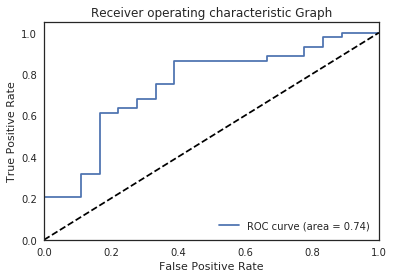

In [144]:
# plot ROC
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Graph')
plt.legend(loc="lower right")
plt.show()

**Grid Search**

In [52]:
# instantiate model
gbt_2 = GBTClassifier()

# grid-search
paramGrid = ParamGridBuilder() \
                .addGrid(gbt_2.maxIter, [10, 20]) \
                .addGrid(gbt_2.maxDepth, [4, 8]) \
                .build()
#                .addGrid(gbt_2.stepSize, [0.05, 0.1, 0.2]) \# it was taking too long to run this step

# cross-validation
cv = CrossValidator(estimator=gbt_2,
                    estimatorParamMaps=paramGrid,
                    evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                    numFolds=3)

In [50]:
new_rf = RandomForestClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(new_rf.maxDepth, [5, 10, 15, 20]) \
    .addGrid(new_rf.numTrees, [10, 20, 30, 50]) \
    .build()

cv = CrossValidator(estimator=new_rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)

In [53]:
start_time = time.time()
cvModel = cv.fit(train)
end_time = time.time()
print('elapsed time = {}'.format(end_time-start_time))

elapsed time = 4271.277796983719


In [54]:
cvModel.avgMetrics

[0.7610123989960731,
 0.7179668284931444,
 0.7467246839100387,
 0.7136639025034713]

In [55]:
# get best parameters
best_model = cvModel.bestModel

In [56]:
best_model

GBTClassificationModel (uid=GBTClassifier_f0b67819eb7a) with 10 trees

In [57]:
# transform test set
results = cvModel.transform(test)

In [58]:
# evaluate results
evaluate_model(results, gbt_2)

Model: GBTClassifier_f0b67819eb7a
-------------------------------
Accuracy : 0.71
F1 score: 0.68


In [ ]:
# This is not as good as the orginal model, however it was taking such a long time to run on my machine 
# and the Udacity session reguarly time-out on me. Hopefully, this demonstrates the proess that I followed though.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.